In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.models import load_model, Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageOps, ImageEnhance
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

In [5]:
(x_train, y_train), (x_valid, y_valid) = mnist.load_data('/content/drive/MyDrive/Colab Notebooks/MNIST/dataset.npz')

# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_valid = x_valid.reshape(x_valid.shape[0], 28, 28, 1)

# RGB to grayscale
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_train /= 255
x_valid /= 255

print('MNIST Dataset Shape:')
print('x_train: ' + str(x_train.shape))
print('y_train: ' + str(y_train.shape))
print('x_valid: ' + str(x_valid.shape))
print('y_valid: ' + str(y_valid.shape))

MNIST Dataset Shape:
x_train: (60000, 28, 28, 1)
y_train: (60000,)
x_valid: (10000, 28, 28, 1)
y_valid: (10000,)


In [ ]:
train_datagen = ImageDataGenerator(featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   validation_split = 0.2)


train_set = train_datagen.flow(x_train, y_train,
                               batch_size = 32,
                               subset = 'training')

valid_set = valid_datagen.flow(x_valid, y_valid,
                               batch_size = 32,
                               subset = 'validation')

In [67]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='/content/drive/MyDrive/Colab Notebooks/MNIST/capture.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [135]:
INPUT_SHAPE = (28, 28, 1)

model = Sequential()

model.add(Conv2D(64,
                 kernel_size = (3,3),
                 input_shape = INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense (Dense)               (None, 128)               1384576   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.0001,
                               decay = 1e-6,
                               amsgrad = 'True'),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model.fit(x = x_train,
          y = y_train,
          epochs = 3)

Epoch 1/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3760 - accuracy: 0.8957
Epoch 2/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1699 - accuracy: 0.9504
Epoch 3/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1238 - accuracy: 0.9635


In [ ]:
model.evaluate(x_valid, y_valid)

313/313 [==============================] - 1s 4ms/step - loss: 0.0869 - accuracy: 0.9744


[0.0869264081120491, 0.974399983882904]

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/MNIST/model.h5')

In [3]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/MNIST/model.h5')

In [128]:
take_photo()

<IPython.core.display.Javascript object>

'/content/drive/MyDrive/Colab Notebooks/MNIST/capture.jpg'

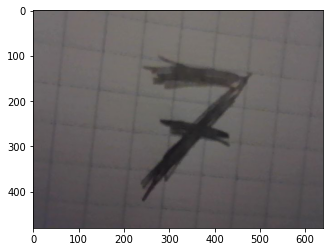

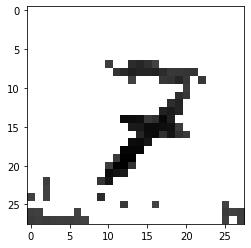

[[3.3686412e-08 8.6279695e-09 2.3087306e-02 3.4189180e-02 1.6481216e-06
  1.5613792e-06 3.5547840e-09 8.8999182e-01 3.4953218e-02 1.7775247e-02]]
7


In [125]:
raw_img = tf.keras.utils.load_img('/content/drive/MyDrive/Colab Notebooks/MNIST/capture.jpg')
plt.imshow(raw_img)
plt.show()

# Load image as grayscale
inp_img = Image.open('/content/drive/MyDrive/Colab Notebooks/MNIST/capture.jpg').convert('L')
# Resize to 28*28px
inp_img = ImageOps.fit(inp_img, (28, 28), method = 0, bleed = 0.0, centering =(0.5, 0.5))
inp_img = ImageOps.invert(inp_img)

inp_img = np.asarray(inp_img)

# Turn gray-ish pixels to white
threshold = 180
inp_img = np.where(inp_img < threshold, 0, inp_img)
# Darken black-ish pixels
inp_img = (inp_img / 1000) * 9

plt.imshow(inp_img.reshape(28, 28), cmap = 'Greys')
plt.show()

img_pred = model.predict(inp_img.reshape(1, 28, 28, 1))
print(img_pred)
print(img_pred.argmax())

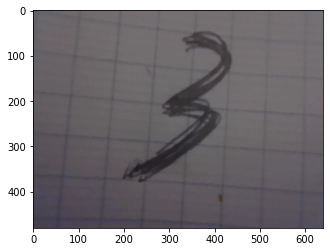

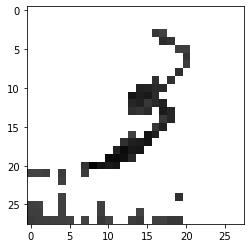

[[1.2501826e-07 1.2372904e-02 2.1281713e-04 8.8883322e-01 3.5667670e-04
  2.0508599e-03 6.1257728e-05 2.8566506e-02 6.8899809e-04 6.6856548e-02]]
3


In [121]:
raw_img = tf.keras.utils.load_img('/content/drive/MyDrive/Colab Notebooks/MNIST/capture.jpg')
plt.imshow(raw_img)
plt.show()

# Load image as grayscale
inp_img = Image.open('/content/drive/MyDrive/Colab Notebooks/MNIST/capture.jpg').convert('L')
# Resize to 28*28px
inp_img = ImageOps.fit(inp_img, (28, 28), method = 0, bleed = 0.0, centering =(0.5, 0.5))
inp_img = ImageOps.invert(inp_img)

inp_img = np.asarray(inp_img)

# Turn gray-ish pixels to white
threshold = 180
inp_img = np.where(inp_img < threshold, 0, inp_img)
# Darken black-ish pixels
inp_img = (inp_img / 1000) * 9

plt.imshow(inp_img.reshape(28, 28), cmap = 'Greys')
plt.show()

img_pred = model.predict(inp_img.reshape(1, 28, 28, 1))
print(img_pred)
print(img_pred.argmax())

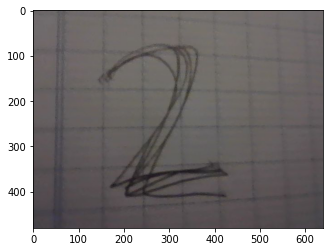

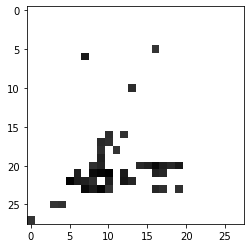

[[2.5749933e-03 1.1749222e-02 9.7413766e-01 1.2699219e-03 1.1606891e-08
  8.0698328e-03 4.1789151e-04 7.1061669e-07 1.7797768e-03 2.0061028e-08]]
2


In [134]:
raw_img = tf.keras.utils.load_img('/content/drive/MyDrive/Colab Notebooks/MNIST/capture.jpg')
plt.imshow(raw_img)
plt.show()

# Load image as grayscale
inp_img = Image.open('/content/drive/MyDrive/Colab Notebooks/MNIST/capture.jpg').convert('L')
# Resize to 28*28px
inp_img = ImageOps.fit(inp_img, (28, 28), method = 0, bleed = 0.0, centering =(0.5, 0.5))
inp_img = ImageOps.invert(inp_img)

inp_img = np.asarray(inp_img)

# Turn gray-ish pixels to white
threshold = 185
inp_img = np.where(inp_img < threshold, 0, inp_img)
# Darken black-ish pixels
inp_img = (inp_img / 1000) * 9

plt.imshow(inp_img.reshape(28, 28), cmap = 'Greys')
plt.show()

img_pred = model.predict(inp_img.reshape(1, 28, 28, 1))
print(img_pred)
print(img_pred.argmax())